**Dataset used:** https://ucdp.uu.se/country/771

**Goal of ML:** To predict the likelihood of cross-border conflict events involving Bangladesh using historical event-level data, in a theoretical early-warning scenario intended to inform preparedness and alertness planning.

# Initial Setup

In [59]:
%pip install ydata-profiling gradio

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from ydata_profiling import ProfileReport
import gradio as gr
import pickle

print("Libraries loaded successfully.")

Libraries loaded successfully.


# Task 1: Data Loading

In [61]:
df = pd.read_csv('gedevents-2026-01-17.csv', index_col=False)
print(f"Data loaded. Shape: {df.shape}")
df.head()

Data loaded. Shape: (693, 47)


,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,...,date_prec,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best_est,high_est,low_est
0,210432,BNG-2015-3-2087-0,2015,False,Clear,3,1218,2009,JMB - Civilians,1218,...,1,09/04/2015 00:00:00,09/04/2015 00:00:00,0,0,2,0,2,2,2
1,210433,BNG-2015-3-1076-1,2015,True,Clear,3,234,506,IS - Civilians,234,...,1,09/28/2015 00:00:00,09/28/2015 00:00:00,0,0,1,0,1,1,1
2,210436,BNG-2015-3-1076-2,2015,True,Clear,3,234,506,IS - Civilians,234,...,1,10/03/2015 00:00:00,10/03/2015 00:00:00,0,0,1,0,1,1,1
3,210459,BNG-2015-3-1076-3,2015,True,Clear,3,234,506,IS - Civilians,234,...,1,10/24/2015 00:00:00,10/24/2015 00:00:00,0,0,1,0,1,1,1
4,210470,BNG-2015-1-14718-0,2015,False,Clear,1,13674,13674,Bangladesh: Islamic State,14718,...,1,11/04/2015 00:00:00,11/04/2015 00:00:00,1,0,0,0,1,1,1


In [62]:
# Subtask: EDA
# ProfileReport(df, title="EDA", explorative=True).to_file("report.html") #For generating downloadeable HTML
# ProfileReport(df, title="EDA", explorative=True) # To view inside colab without requiring download



*   The dataset contains event-level armed conflict records from the Uppsala Conflict Data Program (UCDP).

*   Each row represents a single conflict event with temporal, geographic, and conflict-related attributes.

*   The objective is to predict whether an event involved a cross-border incident.

# Task 2: Data Preprocessing

In [63]:
# keywords = ['border', 'bsf', 'bgb', 'bgp', 'bdr', 'epr', 'rifles','crossing', 'fence', 'pushback', 'no man\'s land', 'zero line']

# 1. Target Definition: Identify Border Violations (Class 1) vs Internal (Class 0)
def define_target(row):
    text = f"{str(row['side_a'])} {str(row['side_b'])} {str(row.get('source_headline', ''))}".lower()
    keywords = ['border', 'bsf', 'bgb', 'bgp', 'bdr', 'epr', 'rifles','crossing', 'fence', 'pushback', 'no man\'s land', 'zero line']
    return 1 if any(k in text for k in keywords) else 0

df['is_border_violation'] = df.apply(define_target, axis=1)

# 2. Feature Extraction (Temporal)
df['month'] = pd.to_datetime(df['date_start']).dt.month

# 3. Handling Missing Values
df = df.dropna(subset=['latitude', 'longitude', 'year', 'type_of_violence', 'month'])

# 4. Feature Selection
X = df[['latitude', 'longitude', 'year', 'month', 'type_of_violence']]
y = df['is_border_violation']

# 5. Stratified Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Total Events: {len(df)}")
print(f"Identified Border Violations: {df['is_border_violation'].sum()}")

Total Events: 693
Identified Border Violations: 8


# Task 3: Pipeline Creation

In [64]:
# Scaling numerical coordinates/years and encoding categorical violence types
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['latitude', 'longitude', 'year', 'month']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['type_of_violence'])
])

custom_weights = {0: 1, 1: 100} # Forces the model to value 1 border event as much as 100 internal ones

pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=500,        # More trees to reduce variance on the 8 samples
        class_weight=custom_weights,
        min_samples_leaf=1,      # REQUIRED: With only 8 samples, we can't require 2 per leaf
        max_depth=None,          # Let the tree grow deep enough to capture the specific border coords
        random_state=42,
        criterion='entropy'      # Often better for heavily imbalanced classes
    ))
])

# Task 4: Primary Model Selection


**Selection:** Random Forest Classifier.

**Justification:** The YData showed that conflict events are non-linearly distributed across coordinates. Random Forest is ideal for this dataset because it handles the non-linear relationship between geography and conflict types well.
It is inherently robust to the noise present in UCDP event reporting and offers 'class_weight' parameters to handle the rarity of border events.

# Task 5: Model Training

In [65]:
pipeline.fit(X_train, y_train)
print("Initial Model Training Complete.")

Initial Model Training Complete.


# Task 6: Cross-Validation

In [72]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Recall score
# cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='recall')
# print(f"CV Recall (Border Detection Rate): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Seeing the F1_macro score because accuracy can be misleading for this imbalanced dataset
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')
print(f"CV F1_macro Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

CV F1_macro Score: 0.5977 (+/- 0.2011)


# Task 7: Hyperparameter Tuning

In [67]:
# param_grid = {
#     'clf__n_estimators': [50, 100],
#     'clf__max_depth': [None, 10, 20]
# }
# grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1')
# grid.fit(X_train, y_train)

param_grid = {'clf__n_estimators': [100, 200], 'clf__max_depth': [None, 15], 'clf__max_features': ['sqrt', 'log2']}
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid.best_params_}")
print(f"Best Grid Score: {grid.best_score_:.4f}")

Best Hyperparameters: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__n_estimators': 100}
Best Grid Score: 0.6088


# Task 8: Best Model Selection

In [68]:
best_model = grid.best_estimator_
print("Best model selected from Grid Search results.")

Best model selected from Grid Search results.


# Task 9: Model Performance Evaluation


--- FINAL TACTICAL PERFORMANCE (Threshold: 0.20) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       137
           1       1.00      1.00      1.00         2

    accuracy                           1.00       139
   macro avg       1.00      1.00      1.00       139
weighted avg       1.00      1.00      1.00       139



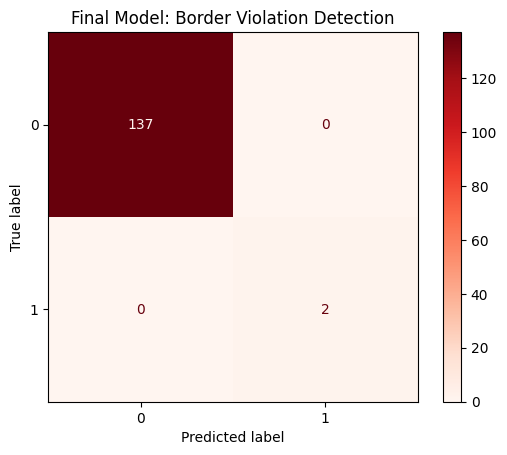

In [69]:
probs = best_model.predict_proba(X_test)[:, 1]
y_pred = (probs >= 0.20).astype(int)

print("\n--- FINAL TACTICAL PERFORMANCE (Threshold: 0.20) ---")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Reds')
plt.title("Final Model: Border Violation Detection")
plt.show()

# Task 10: Web Interface (Gradio)

In [70]:
# # Ensure these match your preprocessing exactly
# SECTORS = {
#     "Teknaf Border": (20.86, 92.30), "Ukhiya Zone": (21.16, 92.14),
#     "Bandarban Hills": (22.19, 92.21), "Sylhet Border": (24.89, 91.86),
#     "Dhaka Central": (23.81, 90.41)
# }
# MONTHS = {"Jan":1,"Feb":2,"Mar":3,"Apr":4,"May":5,"Jun":6,"Jul":7,"Aug":8,"Sep":9,"Oct":10,"Nov":11,"Dec":12}
# # Note: Check if your data uses 1, 2, 3 for violence types
# V_TYPES = {"State-based Action": 1, "Non-state Activity": 2, "Civilian Attacks": 3}

# def tactical_predict(year, sector, month, violence):
#     try:
#         # A. Map Inputs
#         lat, lon = SECTORS[sector]
#         m_num = MONTHS[month]
#         vt = V_TYPES[violence]

#         # B. Create input DataFrame
#         input_data = pd.DataFrame(
#             [[float(lat), float(lon), int(year), int(m_num), int(vt)]],
#             columns=['latitude', 'longitude', 'year', 'month', 'type_of_violence']
#         )

#         # C. Predict Probability
#         prob_array = best_model.predict_proba(input_data)
#         risk_prob = float(prob_array[0][1])

#         # D. Status Logic (Tactical Threshold 0.20)
#         if risk_prob >= 0.20:
#             status = "🔴 HIGH ALERT: Possible Border Violation"
#         elif risk_prob >= 0.10:
#             status = "🟡 MONITOR: Elevated Pattern"
#         else:
#             status = "🟢 STABLE: Routine Activity"

#         # E. RETURN A FORMAT COMPATIBLE WITH gr.JSON
#         return {
#             "Tactical_Status": status,
#             "Border_Violation_Probability": f"{risk_prob:.2%}",
#             "Internal_Conflict_Probability": f"{1 - risk_prob:.2%}",
#             "Sector": sector,
#             "Forecast_Year": int(year),
#             "Forecast_Month": month,
#             "Conflict_Category": violence
#         }

#     except Exception as e:
#         return {"Error": str(e)}

# # Use gr.JSON instead of gr.Label to prevent the "Pill Error"
# ui = gr.Interface(
#     fn=tactical_predict,
#     inputs=[
#         gr.Number(value=2026, label="Forecast Year"),
#         gr.Dropdown(choices=list(SECTORS.keys()), label="Sector Selection", value="Teknaf Border"),
#         gr.Dropdown(choices=list(MONTHS.keys()), label="Forecast Month", value="Jan"),
#         gr.Dropdown(choices=list(V_TYPES.keys()), label="Conflict Category", value="State-based Action")
#     ],
#     outputs=gr.JSON(label="Tactical Assessment Report"),
#     title="2026 Early Warning Detector",
#     description="Operational tool to flag high-probability border events. Uses a 20% sensitivity threshold."
# )

# # Set debug=True to see specific errors in the Colab logs if they occur
# ui.launch(share=True, pwa=True)

# Pickling the Model

In [71]:
# with open('model.pkl', 'wb') as f:
#     pickle.dump(best_model, f)
# print("Model pickled for Hugging Face deployment.")